Note: must turn off radar in settings before recording

In [13]:
# Mounting Drive (where training data was stored)
from google.colab import drive 
drive.mount('/content/drive')

# Tensorflow 2.x is used 
%tensorflow_version 2.x

# Imports
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten
import keras.backend as K

import os
import random
from random import shuffle

import numpy as np
from PIL import Image
import cv2
import statistics
import matplotlib.pyplot as plt 

# Training is done on a GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

#import typing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Next steps: use GAN to debias dataset (MIT 6.S191 lec 4, lab 2)

# Function for data processing which opens up a specified number of files and resizes the images
# Returns a less skewed labeled training set
def data_processing(start_val,num_files):
  """
  In order to ensure the training set isn't skewed towards any one action, each datapoint will be added to a list of similar actions
  The training set will be made up of equal numbers of datapoints from each list
  These lists are initialized here
  """
  sharp_turn_l = []
  sharp_turn_r = []
  medium_turn_l = []
  medium_turn_r = []
  slight_turn_l = []
  slight_turn_r = []
  no_turn = []

  balanced_data = []
  file_number_to_open = start_val
  continue_loop = True
  
  #Loops through all files and stores their data
  while continue_loop:
    data_file_location = '/content/drive/MyDrive/GTA Driving Data/processed-training_data-{}.npy'.format(file_number_to_open)

    # Checks to see if the data file exists
    if os.path.isfile(data_file_location) and file_number_to_open < start_val + num_files:
      processed_data = np.load(data_file_location,allow_pickle=True)
     
      print("File {} opened".format(file_number_to_open))
      file_number_to_open += 1

      # Iterates through datapoints in each file
      for entry in processed_data:

        y = entry[0] # entry[0] is a list of values (left stick position, right stick position, etc..) from the controller
        y_ls = round(y[2],2) # Currently, only the left_stick's x-value is used as a label
        x_raw= entry[1] # entry[1] is the image 

        # Randomly changes the size of 1 in every 4 images, and then resizes the image to (160,120). 
        # This was found to greatly reduce overfitting
        if (random.randrange(4)==2):
          x_val = random.randrange(155,165)
          y_val = random.randrange(115,125)
          x_resized = cv2.resize(x_raw,(x_val, y_val))
          x = cv2.resize(x_resized,(160, 120))
        else:
          x = cv2.resize(x_raw,(160, 120))        
        
        # Each datapoint is added to a list of similar actions based on the left stick's position

        if y_ls > 0.8:
          # Sharp turn
          sharp_turn_r.append([x,y_ls])
        elif y_ls < 0.2:
          # Sharp turn
          sharp_turn_l.append([x,y_ls])

        elif y_ls > 0.68:
          # Medium turn
          medium_turn_r.append([x,y_ls])          
        elif y_ls < 0.32:
          # Medium turn
          medium_turn_l.append([x,y_ls])

        elif y_ls > 0.56:
          # Light turn
          slight_turn_r.append([x,y_ls])          
        elif y_ls < 0.34:
          # Light turn
          slight_turn_l.append([x,y_ls])
          
        else:
          no_turn.append([x,y_ls])
    else:
      if (file_number_to_open > start_val + num_files):
        # Breaks loop if current file is not found and there are no more files
        continue_loop = False
        break

      else:
        # Goes to next file if the current file is not found and there are still more files
        print("file {} not found".format(file_number_to_open))
        file_number_to_open += 1
  
  # Shuffling lists prior to pruning in order to ensure that all files are used in training
  shuffle(slight_turn_l)
  shuffle(slight_turn_r)
  shuffle(medium_turn_l)
  shuffle(medium_turn_r)
  shuffle(no_turn)
  
  # Balancing l/r data
  slight_turn_l = slight_turn_l[0:len(slight_turn_r)]
  slight_turn_r = slight_turn_r[0:len(slight_turn_l)]
  medium_turn_l = medium_turn_l[0:len(medium_turn_r)]
  medium_turn_r = medium_turn_r[0:len(medium_turn_l)]

  balanced_data = no_turn[0:len(slight_turn_l+slight_turn_r)] + slight_turn_l + slight_turn_r + medium_turn_l + medium_turn_r + sharp_turn_l + sharp_turn_r
  

  # Shuffling balanced_data so that validation set isn't only made up of sharp_turn_r
  shuffle(balanced_data)
  
  X = []
  Y = []

  X , Y = zip(*balanced_data)

  print("Done! have {} test cases".format(len(balanced_data)))
  
  return X,Y
 

In [4]:
# Defines the neural network that will be trained on the player's data 
# Returns uncompiled network
def build_driving_model():
  """
  Transfer learning: a ResNet50 trained on imagenet is used with its last 4 layers removed.
  Trainable fully connected layers are added on top of the imagenet conv layers
  Dropout was initially used but was later removed for performance reasons
  https://towardsdatascience.com/pitfalls-with-dropout-and-batchnorm-in-regression-problems-39e02ce08e4d
  """
  resnet = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(120, 160, 3))

  for layer in resnet.layers[:-4]:
      layer.trainable = False
  
  # Prints network details for debugging
  """
  for layer in resnet.layers:
      print(layer, layer.trainable)
  """
  
  model = Sequential()
  model.add(resnet)
  # model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(200, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(50, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(10, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(1))
  return model

"""
These metrics check the accuracy of the network. 
The second metric (which has a larger allowed error) determines whether the network's prediction is 'in the ballpark'
"""
accepted_diff = 0.03 
def linear_regression_equality(y_true, y_pred):
    diff = K.abs(y_true-y_pred)
    return K.mean(K.cast(diff < accepted_diff, tf.float32))

wide_accepted_diff = 0.05 
def wide_linear_regression_equality(y_true, y_pred):
    diff = K.abs(y_true-y_pred)
    return K.mean(K.cast(diff < wide_accepted_diff, tf.float32))

In [32]:
# Function for training model
# Returns trained model
def train_model(EPOCHS,BATCH_SIZE):

  # Lists are initialized for training performance data
  test_acc   = []
  test_loss  = []
  train_acc  = []
  train_loss = []
  wide_train_acc = []
  wide_test_acc = []

  # Program asks user if they want to load a pretrained model
  epoch_to_load = int(input("What epoch to load? If starting training from scratch, enter 0: "))
  if epoch_to_load > 0:
    # Initializes neural net
    cnn_model = build_driving_model()
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=2e-3,
        decay_steps=10000,
        decay_rate=0.95)
    optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
    cnn_model.compile(loss='mse', optimizer=optimizer, metrics=[linear_regression_equality,wide_linear_regression_equality])
    
    # IMPORTANT: This value will be different for other users
    file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/resnet_model_epoch_{}.ckpt".format(epoch_to_load)

    # Loads weights from previous training 
    cnn_model.load_weights(file_name).expect_partial()

    # Loads performance data from past training, and plots it
    performance_data = np.load('/content/drive/MyDrive/GTA Driving Data/progress data/resnet_graph_data.npy',allow_pickle=True)
    
    train_acc = performance_data[0][0:epoch_to_load].tolist()
    test_acc = performance_data[1][0:epoch_to_load].tolist()
    train_loss = performance_data[2][0:epoch_to_load].tolist()
    test_loss = performance_data[3][0:epoch_to_load].tolist()
    wide_train_acc = performance_data[4][0:epoch_to_load].tolist()
    wide_test_acc = performance_data[5][0:epoch_to_load].tolist()
    
    # Plotting performance data
    f1 = plt.figure(figsize=(12, 4))
    f1.add_subplot(131).plot(train_acc, "-b",label = "train accuracy")
    f1.add_subplot(131).plot(test_acc, "-r",label = "test accuracy")
    f1.add_subplot(131).legend(loc='lower right')
    
    f1.add_subplot(132).plot(train_loss, "-b",label = "train loss")
    f1.add_subplot(132).plot(test_loss, "-r",label = "test loss")
    f1.add_subplot(132).legend(loc='upper right')
    
    f1.add_subplot(133).plot(wide_train_acc, "-b",label = "train accuracy (wide)")
    f1.add_subplot(133).plot(wide_test_acc, "-r",label = "test accuracy (wide)")
    f1.add_subplot(133).legend(loc='lower right')

    plt.show()

  else:
    # Initializes neural network
    cnn_model = build_driving_model()

    # Custom decaying lr schedule
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=1.2e-2,
      decay_steps=10000,
      decay_rate=0.95)
    optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
    cnn_model.compile(loss='mse', optimizer=optimizer, metrics=[linear_regression_equality,wide_linear_regression_equality])

  
  file_num_to_open = 0 
  # Number of files to be retrieved at once (to keep RAM usage low)
  num_files_to_retrieve = 20 
  
  # Number of files in dataset
  num_files_to_test = 233 
  
  # Training loop
  for epoch in range(epoch_to_load+1,EPOCHS+1):
    # Initalize empty lists for epoch performance data to be averaged
    epoch_test_acc   = []
    epoch_test_loss  = []
    epoch_train_acc  = []
    epoch_train_loss = []
    epoch_wide_train_acc  = []
    epoch_wide_test_acc  = []

    print('----- --------STARTING EPOCH {}-------------'.format(epoch))

    while file_num_to_open < num_files_to_test:      
      # Loads data and labels
      X, Y= data_processing(file_num_to_open,num_files_to_retrieve)
      file_num_to_open += num_files_to_retrieve
      X_array = np.array(X).reshape(-1,120,160,3)
      Y_array = np.array(Y).reshape(-1,1)

      # Calling fit() to train network, history stores performance
      # 10% of data is used as validation set
      history = cnn_model.fit(X_array, Y_array, batch_size=BATCH_SIZE, epochs=1,validation_split=0.1)
      
      # Performance data is stored
      epoch_train_acc.append(history.history['linear_regression_equality'][0])
      epoch_train_loss.append(history.history['loss'][0])
      epoch_test_loss.append(history.history['val_loss'][0])
      epoch_test_acc.append(history.history['val_linear_regression_equality'][0])
      epoch_wide_test_acc.append(history.history['val_wide_linear_regression_equality'][0])
      epoch_wide_train_acc.append(history.history['wide_linear_regression_equality'][0])
        
    #Resets file counter
    file_num_to_open = 0

    # Prints average performance over epoch
    print("avg train accuracy: {}".format(statistics.mean(epoch_train_acc)))
    print("avg test accuracy: {}".format(statistics.mean(epoch_test_acc)))
    print("avg train accuracy (wide): {}".format(statistics.mean(epoch_wide_train_acc)))
    print("avg test accuracy (wide): {}".format(statistics.mean(epoch_wide_test_acc)))

    # Stores average performance in lists
    train_acc.append(statistics.mean(epoch_train_acc))
    test_acc.append(statistics.mean(epoch_test_acc))
    train_loss.append(statistics.mean(epoch_train_loss))
    test_loss.append(statistics.mean(epoch_test_loss))
    wide_test_acc.append(statistics.mean(epoch_wide_test_acc))
    wide_train_acc.append(statistics.mean(epoch_wide_train_acc))

    #Saves training weights and performance data every 15 epochs
    if epoch % 15 == 0:
          print("SAVED")
          file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/resnet_model_epoch_{}.ckpt".format(epoch)
          cnn_model.save_weights(file_name)
          performance_data = [train_acc,test_acc,train_loss,test_loss,wide_train_acc,wide_test_acc]
          np.save('/content/drive/MyDrive/GTA Driving Data/progress data/resnet_graph_data.npy',performance_data)

    #Plotting Performance Data
    f1 = plt.figure(figsize=(12, 4))
    fig_1 = f1.add_subplot(131)
    fig_2 = f1.add_subplot(132)
    fig_3 = f1.add_subplot(133)
    
    fig_1.plot(train_acc, "-b",label = "train accuracy")
    fig_1.plot(test_acc, "-r",label = "test accuracy")
    fig_1.legend(loc='lower right')
    
    fig_2.plot(train_loss, "-b",label = "train loss")
    fig_2.plot(test_loss, "-r",label = "test loss")
    fig_2.legend(loc='lower right')
    
    fig_3.plot(wide_train_acc, "-b",label = "train accuracy (wide)")
    fig_3.plot(wide_test_acc, "-r",label = "test accuracy (wide)")
    fig_3.legend(loc='lower right')

    plt.show()
  print("done")
  return cnn_model

In [37]:
# Function to test the performance of a pretrained model
# No returned values
def test_model(epochs_trained,model=None):

  if model == None:
    model = build_driving_model()
    #lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate=1e-2,
    #    decay_steps=10000,
    #    decay_rate=0.9)
    #optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
    # optimizer = keras.optimizers.Adam(learning_rate=5e-3)
    # model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    #model.compile(loss='mse', optimizer=optimizer, metrics=[linear_regression_equality])

    file_location = "/content/drive/MyDrive/GTA Driving Data/training weights/resnet_model_epoch_{}.ckpt".format(epochs_trained)
    model.load_weights(file_location).expect_partial()
  
  X, Y= data_processing(0,10)
  X_array = np.array(X).reshape(-1,120,160,3)
  Y_array = np.array(Y).reshape(-1,1)

  score = model.evaluate(X_array, Y_array, verbose=2)
  print("Restored model, accuracy: {:5.2f}%".format(100 * score[1]))

What epoch to load? If starting training from scratch, enter 0: 0
----- --------STARTING EPOCH 1-------------
File 0 opened
file 1 not found
Done! have 416 test cases
6/6 [==============================] - 8s 382ms/step - loss: 1.2214 - linear_regression_equality: 0.0206 - wide_linear_regression_equality: 0.0224 - val_loss: 0.0795 - val_linear_regression_equality: 0.0000e+00 - val_wide_linear_regression_equality: 0.0238
avg train accuracy: 0.025366513058543205
avg test accuracy: 0.0
avg train accuracy (wide): 0.031539350748062134
avg test accuracy (wide): 0.02380952425301075


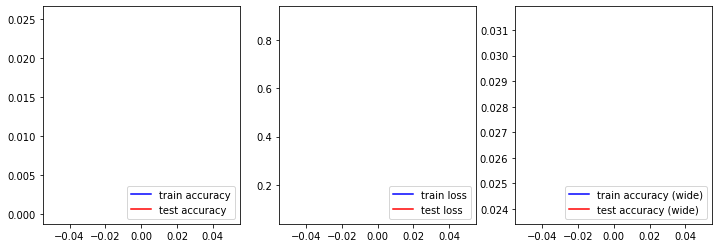

----- --------STARTING EPOCH 2-------------
File 0 opened
file 1 not found
Done! have 416 test cases
6/6 [==============================] - 0s 75ms/step - loss: 0.0836 - linear_regression_equality: 0.0244 - wide_linear_regression_equality: 0.0415 - val_loss: 0.0757 - val_linear_regression_equality: 0.0000e+00 - val_wide_linear_regression_equality: 0.0476
avg train accuracy: 0.024402007460594177
avg test accuracy: 0.0
avg train accuracy (wide): 0.041473764926195145
avg test accuracy (wide): 0.0476190485060215


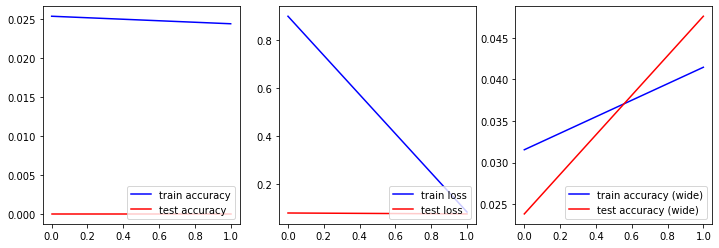

done
File 0 opened
File 1 opened
File 2 opened
File 3 opened
File 4 opened
File 5 opened
File 6 opened
File 7 opened
File 8 opened
File 9 opened
file 10 not found
Done! have 3317 test cases
104/104 - 3s - loss: 0.0726 - linear_regression_equality: 0.0543 - wide_linear_regression_equality: 0.0849
Restored model, accuracy:  5.43%


In [38]:
#Calling functions to train and test model
cnn_model = train_model(150,64)
test_model(150, cnn_model)